## Sagnac Frequency - Backscatter Correction - Temperature

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.compute_cwt import __compute_cwt

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.reduce import __reduce
from functions.multitaper_coherence import __multitaper_coherence
from functions.cross_correlation_function_windows import __cross_correlation_function_windows
from functions.cross_correlation_windows import __cross_correlation_windows
from functions.load_backscatter_data import __load_backscatter_data

In [4]:
def __cc_lag_matrix(dat1, dat2, dt, twin_sec, T_lag_sec, dT_lag_sec, plot=False):

    L, dL = int(T_lag_sec/dt), int(dT_lag_sec/dt)

    Tlags = np.arange(-T_lag_sec, T_lag_sec+dT_lag_sec, dT_lag_sec)
    Nlags = np.arange(-L, L+dL, dL)

    for _k, lag in enumerate(Nlags):

        tt, cc = __cross_correlation_windows(dat1, dat2, dt, twin_sec, overlap=0.5, lag=lag, demean=True)

        if _k == 0:
            ccc = np.zeros((len(Nlags), len(cc)))

        ccc[_k] = cc

    if plot:
        plt.figure(figsize=(15, 5))

        cmap = plt.get_cmap("seismic")

        plt.pcolormesh(tt/86400, Tlags, ccc, vmin=-1, vmax=1, cmap=cmap)
        plt.ylabel("Lag Time (sec)")
        plt.xlabel("Time (days)")

        plt.show();

    return tt, Tlags, ccc

## Configurations

In [79]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

case = 10
# config['tbeg'] = UTCDateTime("2023-12-05 00:00")
# config['tend'] = UTCDateTime("2023-12-16 00:00")

# config['tbeg'] = UTCDateTime("2023-12-08 00:00")
# config['tend'] = UTCDateTime("2023-12-15 00:00")
# flim1, flim2 = 302.425, 302.485

## note air ventilation on from 27-12-2023 !!!
# case = 11
# config['tbeg'] = UTCDateTime("2023-12-24 00:00")
# config['tend'] = UTCDateTime("2023-12-31 00:00")

case = 12
config['tbeg'] = UTCDateTime("2024-01-13 00:00")
config['tend'] = UTCDateTime("2024-01-17 00:00")
flim1, flim2 = 302.375, 302.475

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Configurations

In [80]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Cut corrupt data periods

In [81]:
times = [("2023-12-04T09:11", "2023-12-04T18:01")]

for t1, t2 in times:
    # bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
    # bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)
    bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
    bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)


bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
bs['w_s'] = np.nan_to_num(bs['w_s'], nan=np.nanmedian(bs['w_s']))

(302.375, 302.475)

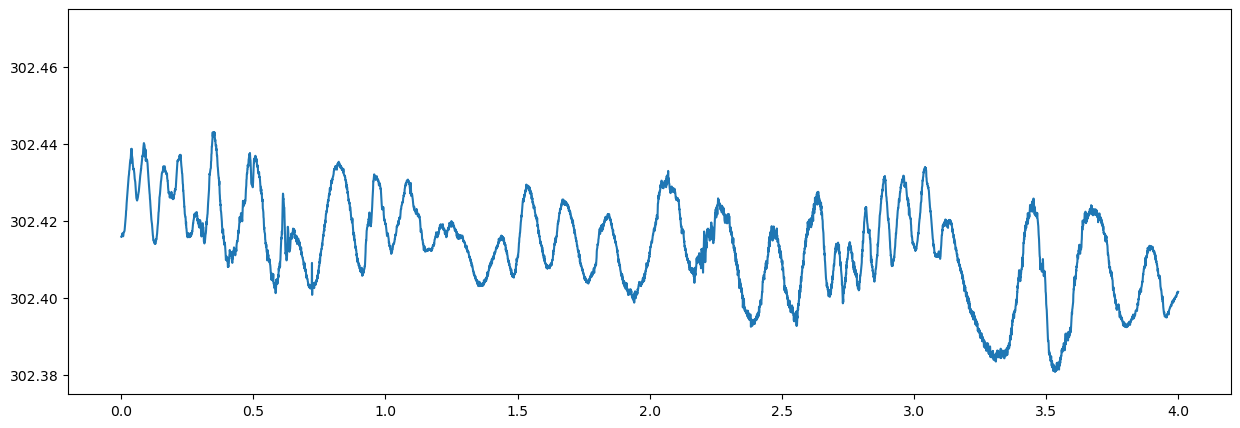

In [82]:
plt.figure(figsize=(15,5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(flim1, flim2)

In [83]:
from functions.load_mlti import __load_mlti

mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [84]:
from functions.get_mlti_intervals import __get_mlti_intervals

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [85]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "w_s", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)

In [86]:
tt1, tt2 = "2023-11-20 14:00", "2024-01-11"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.4
cond4 = bs.fj_fs_nan > 302.6

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['w_s_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.w_s_nan)
bs['w_s_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.w_s_nan)


In [87]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['w_s_inter'] = __interpolate_nan(np.array(bs.w_s_nan))

In [88]:
from functions.smoothing import __smooth

n_minutes = 240

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['w_s_smooth']   = __smooth(bs.w_s_inter, n_minutes)

/tmp/ipykernel_1957241/1523202915.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


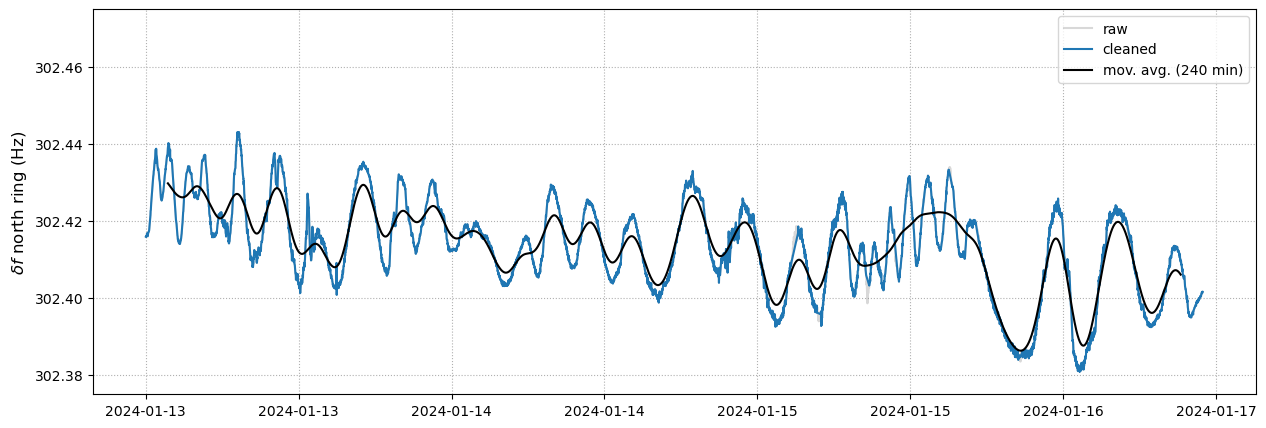

In [89]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_inter, color="tab:blue", label="cleaned")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)


    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax.get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax.set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


0.008066777576619926


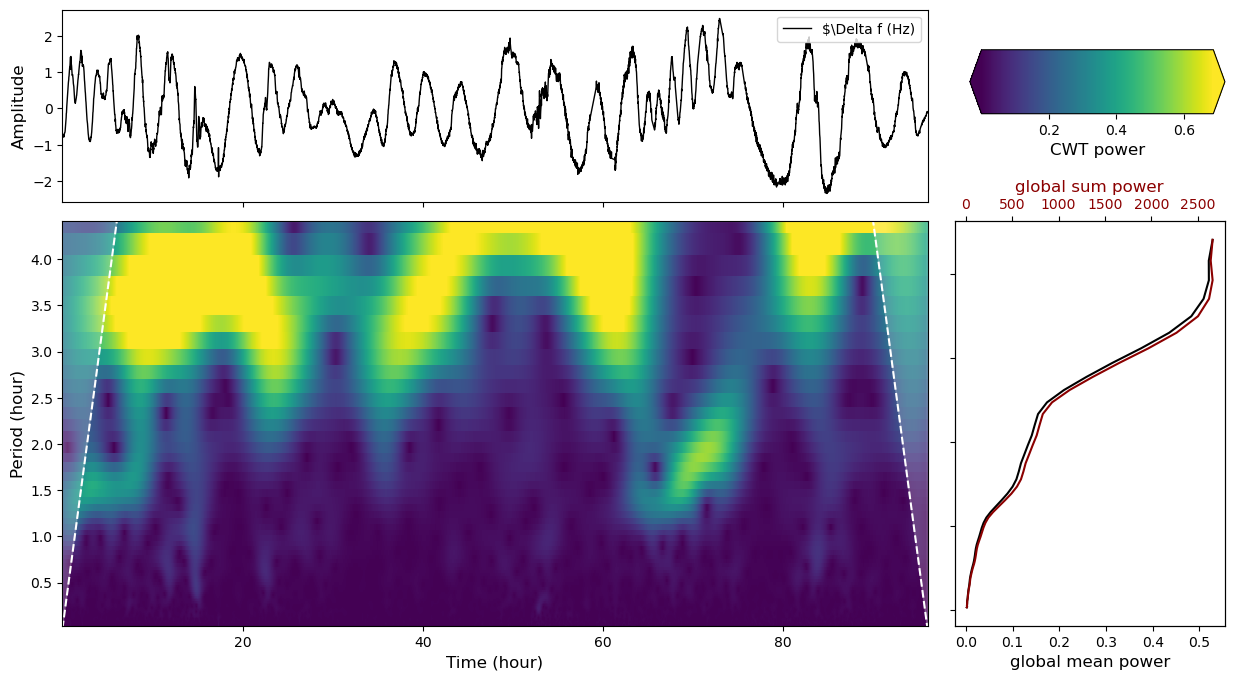

In [90]:
ttt = bs.time_sec
arr = bs.fj_fs_inter
dt  = 60 # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="$\Delta f (Hz)",
                    log=False, period=True, fmax=None, plot=True)

out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT_1.png", format="png", dpi=200, bbox_inches='tight')


### Compute PSD

/tmp/ipykernel_1957241/1647531309.py:49: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim(0, 1e-3)
/tmp/ipykernel_1957241/1647531309.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(tcklbls)


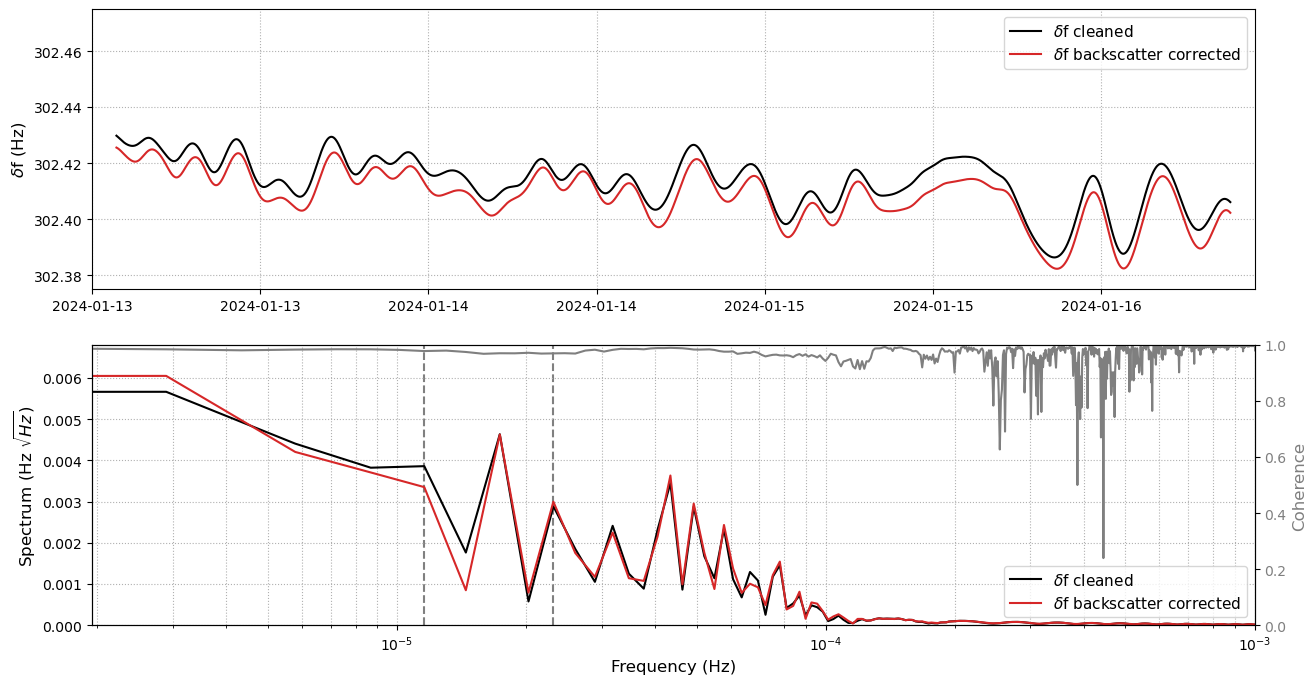

In [91]:
def __makeplot(key1, key2):

    dat1 = np.array((bs[key1] - bs[key1].mean()).replace(np.nan, 0))
    dat2 = np.array((bs[key2] - bs[key2].mean()).replace(np.nan, 0))


    out = __multitaper_coherence(dat1, dat2, 60, n_taper=10, time_bandwidth=3.5, method=0)


    f1, psd1, pha1 = __get_fft(dat1, 60)
    f2, psd2, pha2 = __get_fft(dat2, 60)


    Nrow, Ncol = 2, 1

    font = 12

    time_scaling = 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))


    ax[0].plot(bs.time_sec*time_scaling, bs[key1], color="black", label=f"$\delta$f cleaned")
    ax[0].plot(bs.time_sec*time_scaling, bs[key2], color="tab:red", label=f"$\delta$f backscatter corrected")

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1, psd1, color="black", label=f"$\delta$f cleaned")
    ax[1].semilogx(f2, psd2, color="tab:red", label=f"$\delta$f backscatter corrected")

    # ax[1].semilogx(out['ff1'], out['psd1'], color="black", label=f"$\delta$f w/ backscatter")
    # ax[1].semilogx(out['ff2'], out['psd2'], color="tab:red", label=f"$\delta$f w/o backscatter")

    ax11 = ax[1].twinx()
    ax11.semilogx(out['fcoh'], out['coh'], color="tab:grey", label=f"coherence")
    ax11.set_ylim(0, 1.)
    ax11.set_ylabel(f"Coherence", fontsize=font, color="tab:grey")
    [t.set_color('tab:grey') for t in ax11.yaxis.get_ticklabels()]

    for _n in range(Nrow):
        ax[_n].grid(which="both", ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)

    # ax[0].set_ylim(302.395, 302.465)
    ax[0].set_ylim(flim1, flim2)
    ax[0].set_xlim(0, max(bs.time_sec)*time_scaling)

    ax[1].set_ylim(0, max(psd1)+0.2*max(psd1))
    ax[1].set_xlim(0, 1e-3)

    ax[1].legend(loc=4, fontsize=font-1)

    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    # ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    ax[1].axvline(1/(12*3600), ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600), ls="--", color="grey", zorder=0)

    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax[0].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[0].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot("fj_fs_smooth", "w_s_smooth");

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_temperature_Case{case}_PSD_smooth.png", format="png", dpi=150, bbox_inches='tight')


## Load Pressure Data

In [152]:
# ps = __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])

ps1 = __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
ps5 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
ps9 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps = Stream()
ps += ps1
ps += ps5
ps += ps9

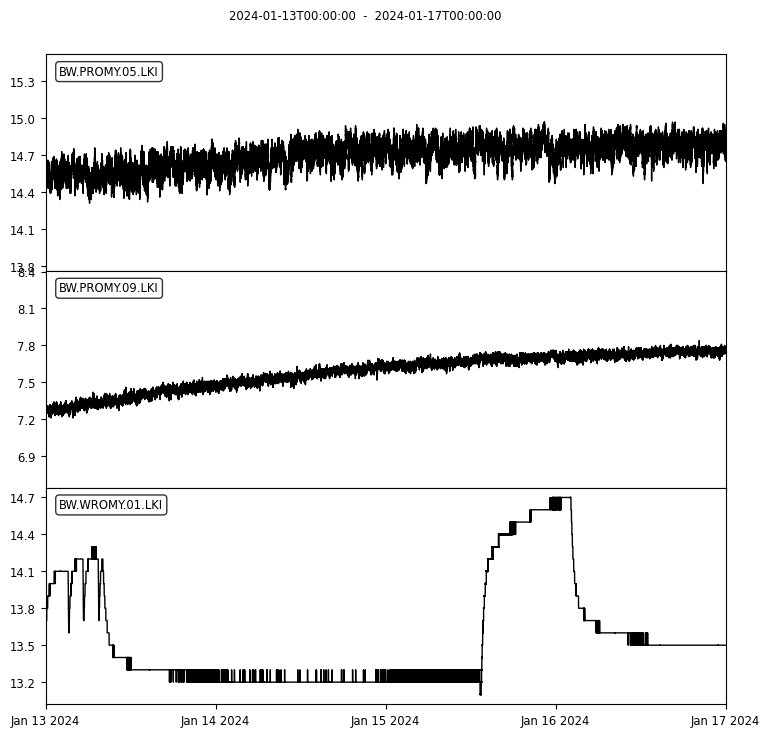

In [153]:
ps.plot();

In [154]:
for tr in ps:
    # tr.data = __smooth(tr.data, 10)
    tr.data = __interpolate_nan(tr.data)
    # tr.data = np.gradient(tr.data)
ps

3 Trace(s) in Stream:
BW.WROMY.01.LKI | 2024-01-13T00:00:00.000000Z - 2024-01-17T00:00:00.000000Z | 1.0 Hz, 345601 samples
BW.PROMY.05.LKI | 2024-01-13T00:00:00.000000Z - 2024-01-17T00:00:00.000000Z | 1.0 Hz, 345601 samples
BW.PROMY.09.LKI | 2024-01-13T00:00:00.000000Z - 2024-01-17T00:00:00.000000Z | 1.0 Hz, 345601 samples

4 Trace(s) in Stream:
BW.ROMY.U.      | 2024-01-13T00:00:00.000000Z - 2024-01-16T23:58:20.000000Z | 100.0 s, 3456 samples
BW.WROMY.01.LKI | 2024-01-13T00:00:00.000000Z - 2024-01-16T23:58:20.000000Z | 100.0 s, 3456 samples
BW.PROMY.05.LKI | 2024-01-13T00:00:00.000000Z - 2024-01-16T23:58:20.000000Z | 100.0 s, 3456 samples
BW.PROMY.09.LKI | 2024-01-13T00:00:00.000000Z - 2024-01-16T23:58:20.000000Z | 100.0 s, 3456 samples


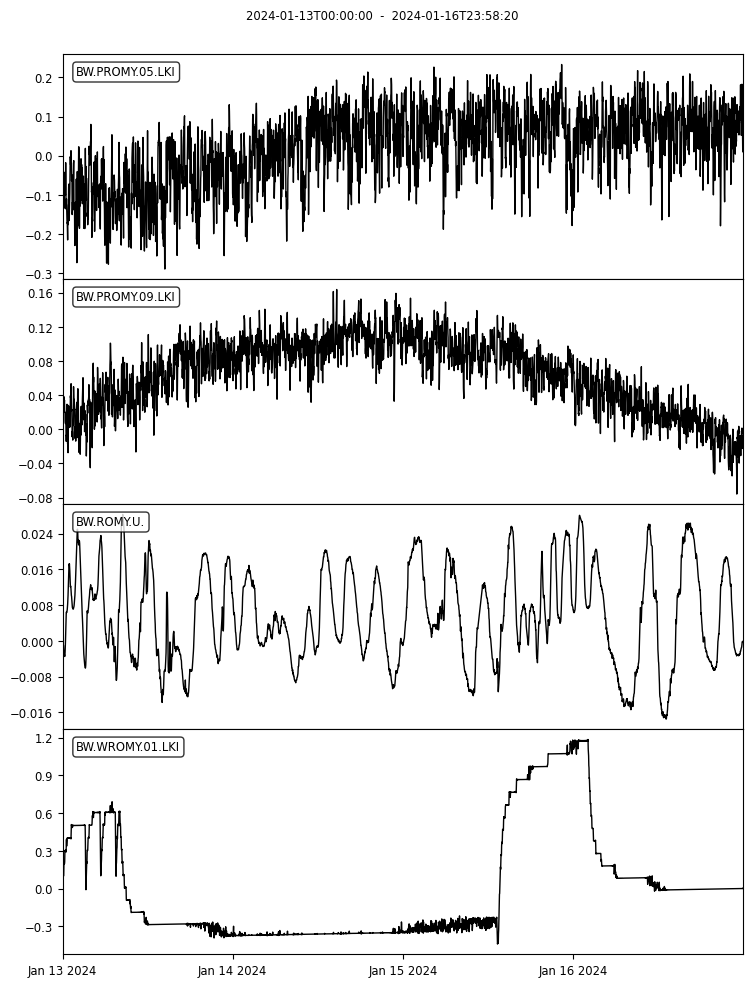

In [156]:
tr00 = Trace()
tr00.data = np.array(bs.w_s_inter)
tr00.stats.delta = 60
tr00.stats.starttime = bs.time1[0]
tr00.stats.network = "BW"
tr00.stats.station = "ROMY"
tr00.stats.location = "U"

st = Stream()
st += tr00.copy()
st += ps.copy()

st = st.detrend("linear")
st = st.detrend("simple")
st = st.filter("lowpass", freq = 0.005, corners=4, zerophase=True)
st = st.resample(0.01, no_filter=True)

print(st)

st.plot(equal_scale=False);

0.004840066545971956


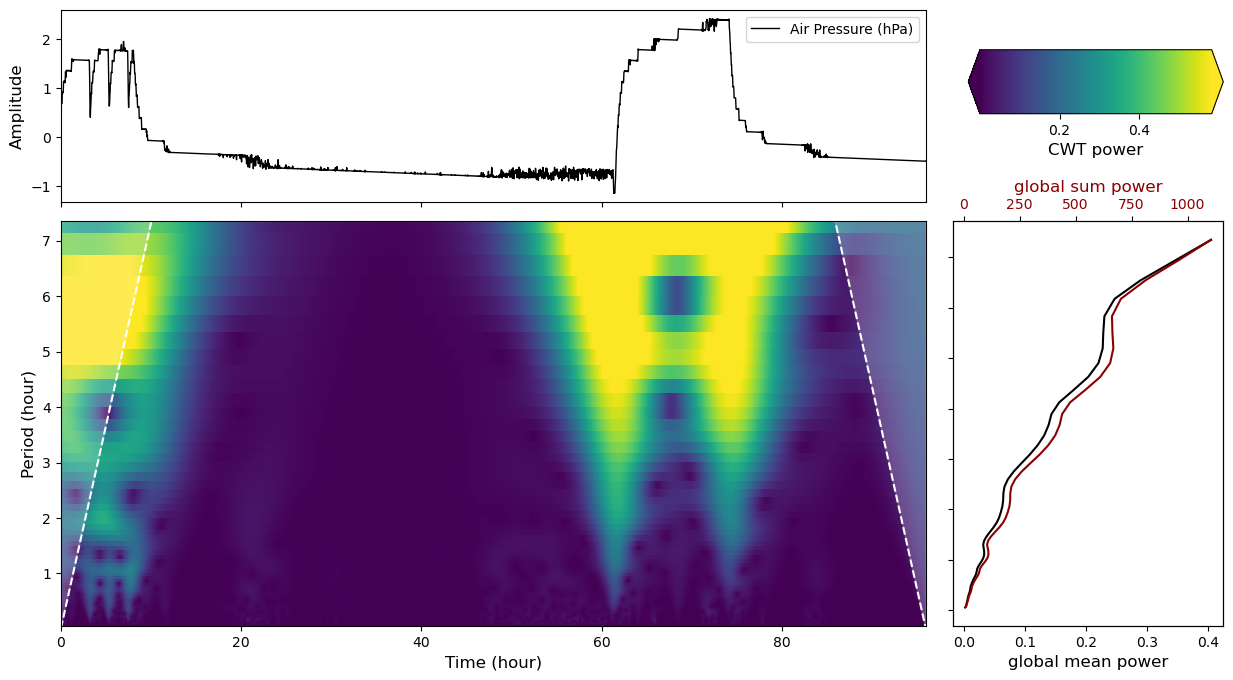

In [157]:
ttt = st[1].times()
arr = st[1].data
dt  = st[1].stats.delta # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="Air Pressure (hPa)",
                    log=False, period=True, fmax=None, plot=True)

out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT_2.png", format="png", dpi=200, bbox_inches='tight')


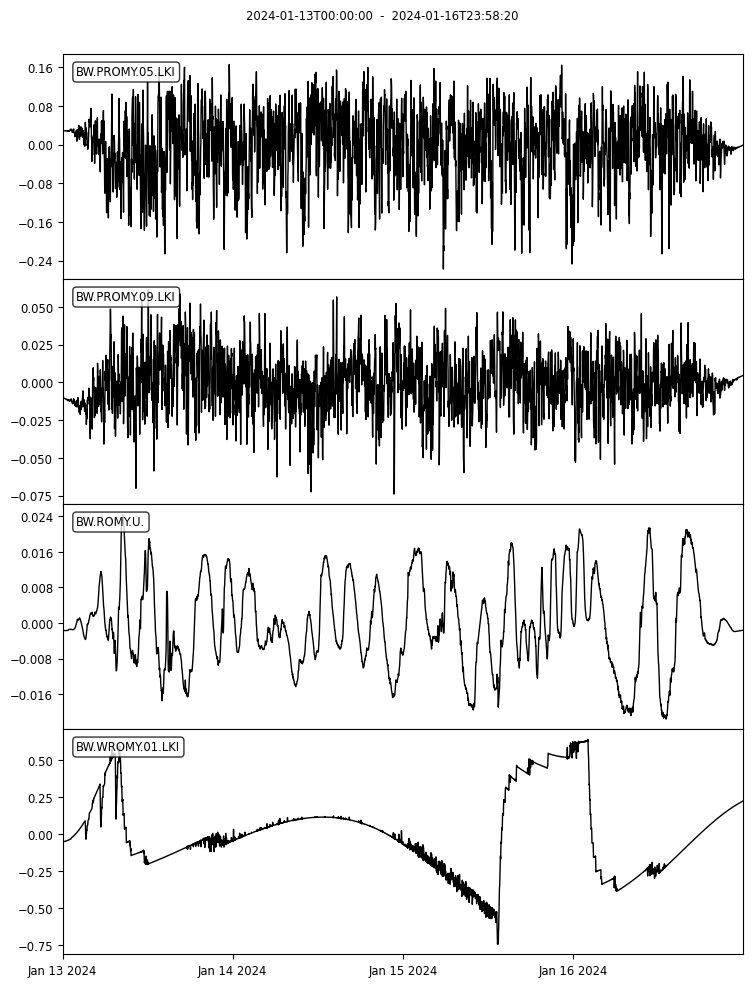

In [158]:
lp = st.copy()

lp = lp.detrend("simple")
lp = lp.taper(0.1)
# lp = lp.filter("bandpass", freqmin=1/(12*3600), freqmax=1/(1*3600), corners=4, zerophase=True)
lp = lp.filter("highpass", freq=1/(48*3600), corners=4, zerophase=True)
# lp = lp.filter("lowpass", freq=0.01, corners=4, zerophase=True)

lp.plot(equal_scale=False);

/tmp/ipykernel_1957241/1442492683.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


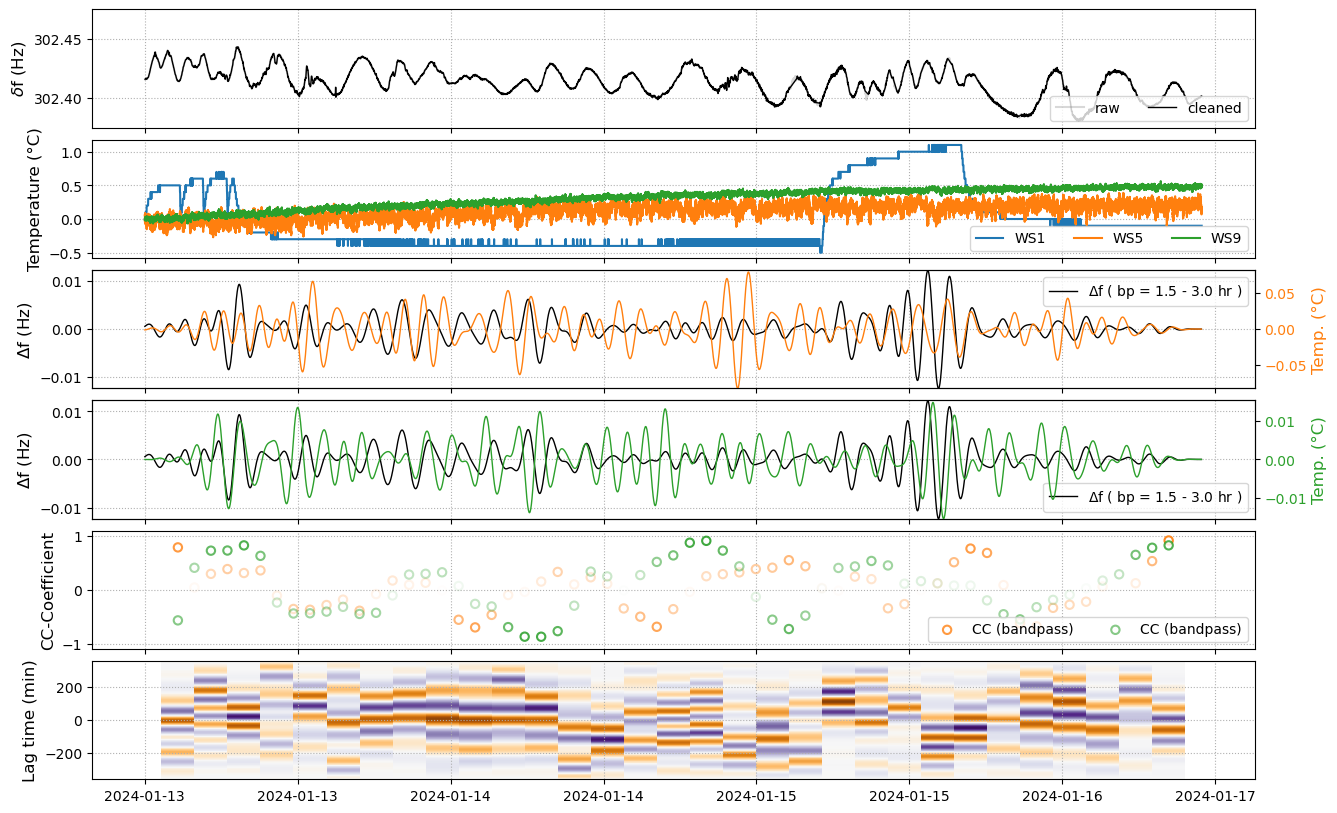

In [185]:
def __makeplot():

    from numpy import nanmax

    fl, fu = 1/(3*3600), 1/(1.5*3600)

    sta1 = "ROMY"
    loc2 = "09"

    lp = st.copy()

    lp = lp.detrend("simple")
    lp = lp.taper(0.1)
    lp = lp.filter("bandpass", freqmin=fl, freqmax=fu, corners=4, zerophase=True)

    env0 = abs(hilbert(lp.select(station=sta1)[0].data))
    env1 = abs(hilbert(lp.select(location=loc2)[0].data))

    env0_smooth = __smooth(env0, 1)
    env1_smooth = __smooth(env1, 1)

    dt = st[0].stats.delta
    over = 0.75
    twin = 2/fl ## seconds

    # tt, cc = __cross_correlation_windows(st.select(station=sta1)[0].data, st.select(location=loc2)[0].data, dt, twin, overlap=over, demean=True)
    tt_lp_05, cc_lp_05 = __cross_correlation_windows(lp.select(station=sta1)[0].data, lp.select(location="05")[0].data, dt, twin, overlap=over, demean=False)
    tt_lp_09, cc_lp_09 = __cross_correlation_windows(lp.select(station=sta1)[0].data, lp.select(location="09")[0].data, dt, twin, overlap=over, demean=False)


    Nrow, Ncol = 6, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(bs.time_sec, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec, bs.fj_fs_inter, color="black", label="cleaned", lw=1)
    # ax[0].plot(bs.time_sec, bs.fj_fs_smooth, color="darkgrey", label=f"mov. avg. ({n_minutes} min)")
    # ax[0].plot(bs.time_sec, __smooth(bs.fj_fs_inter, 720), color="darkred", label=f"mov. avg. ({720} min)")
    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f (Hz)", fontsize=font)


    ax[1].plot(ps.select(location="01")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(ps.select(location="01")[0].data, 100), color="tab:blue", label="WS1")
    ax[1].plot(ps.select(location="05")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(ps.select(location="05")[0].data, 100), color="tab:orange", label="WS5")
    ax[1].plot(ps.select(location="09")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(ps.select(location="09")[0].data, 100), color="tab:green", label="WS9")
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)
    # [t.set_color('tab:purple') for t in ax00.yaxis.get_ticklabels()]


    ax[2].plot(lp.select(station=sta1)[0].times(reftime=UTCDateTime(ref_date)),
               lp.select(station=sta1)[0].data, color="k", label=f"$\Delta$f ( bp = {round(1/fu/3600, 1)} - {round(1/fl/3600,1)} hr )", lw=1)


    ax11 = ax[2].twinx()
    ax11.plot(lp.select(location="05")[0].times(reftime=UTCDateTime(ref_date)),
              lp.select(location="05")[0].data, color="tab:orange", label="PS5", lw=1)
    ax11.set_ylabel("Temp. (°C)", fontsize=font, color="tab:orange")
    [t.set_color('tab:orange') for t in ax11.yaxis.get_ticklabels()]


    max_lim = max([abs(min(lp.select(station=sta1)[0].data)), abs(max(lp.select(station=sta1)[0].data))])
    ax[2].set_ylim(-max_lim, max_lim)

    max_lim = max([abs(min(lp.select(location="05")[0].data)), abs(max(lp.select(location="05")[0].data))])
    ax11.set_ylim(-max_lim, max_lim)

    ax[2].set_ylabel("$\Delta$f (Hz)", fontsize=font)


    ax[3].plot(lp.select(station=sta1)[0].times(reftime=UTCDateTime(ref_date)),
               lp.select(station=sta1)[0].data, color="k", label=f"$\Delta$f ( bp = {round(1/fu/3600, 1)} - {round(1/fl/3600,1)} hr )", lw=1)

    ax33 = ax[3].twinx()
    ax33.plot(lp.select(location="09")[0].times(reftime=UTCDateTime(ref_date)),
              lp.select(location="09")[0].data, color="tab:green", label="PS9", lw=1)
    ax33.set_ylabel("Temp. (°C)", fontsize=font, color="tab:green")
    [t.set_color('tab:green') for t in ax33.yaxis.get_ticklabels()]

    max_lim = max([abs(min(lp.select(station=sta1)[0].data)), abs(max(lp.select(station=sta1)[0].data))])
    ax[3].set_ylim(-max_lim, max_lim)

    max_lim = max([abs(min(lp.select(location="09")[0].data)), abs(max(lp.select(location="09")[0].data))])
    ax33.set_ylim(-max_lim, max_lim)

    ax[3].set_ylabel("$\Delta$f (Hz)", fontsize=font)


    ax[4].scatter(tt_lp_05, cc_lp_05, alpha=abs(cc_lp_05), label="CC (bandpass)", color="w", edgecolor="tab:orange", lw=1.5, zorder=2)
    ax[4].scatter(tt_lp_09, cc_lp_09, alpha=abs(cc_lp_09), label="CC (bandpass)", color="w", edgecolor="tab:green", lw=1.5, zorder=2)
    ax[4].set_ylim(-1.1, 1.1)
    ax[4].set_ylabel("CC-Coefficient", fontsize=font)


    ttt, ccf, tlags, shifts, maxima = __cross_correlation_function_windows(lp[0].data, lp[1].data, dt, twin, overlap=0.5, demean=True)
    cmap = plt.get_cmap("PuOr")
    ax[5].pcolormesh(ttt, tlags/60, ccf.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)
    ax[5].set_ylabel("Lag time (min)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].set_xlim(left=0)

    ax[0].legend(loc=4, ncol=3)
    ax[1].legend(loc=4, ncol=3)
    ax[2].legend(loc=1, ncol=3)
    ax[3].legend(loc=4, ncol=3)
    ax[4].legend(loc=4, ncol=3)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_Case{case}_temperature.png", format="png", dpi=150, bbox_inches='tight')


/tmp/ipykernel_1957241/862978295.py:19: RuntimeWarning: divide by zero encountered in divide
  ax[0].semilogx(1/out['fcoh'], out['coh'])
/tmp/ipykernel_1957241/862978295.py:21: RuntimeWarning: divide by zero encountered in divide
  ax[1].semilogx(1/out['ff1'], out['psd1'])
/tmp/ipykernel_1957241/862978295.py:22: RuntimeWarning: divide by zero encountered in divide
  ax[2].semilogx(1/out['ff2'], out['psd2'])
/tmp/ipykernel_1957241/862978295.py:25: RuntimeWarning: divide by zero encountered in divide
  ax11.loglog(1/f1, psd1, color="tab:orange")
/tmp/ipykernel_1957241/862978295.py:28: RuntimeWarning: divide by zero encountered in divide
  ax22.loglog(1/f2, psd2, color="tab:orange")


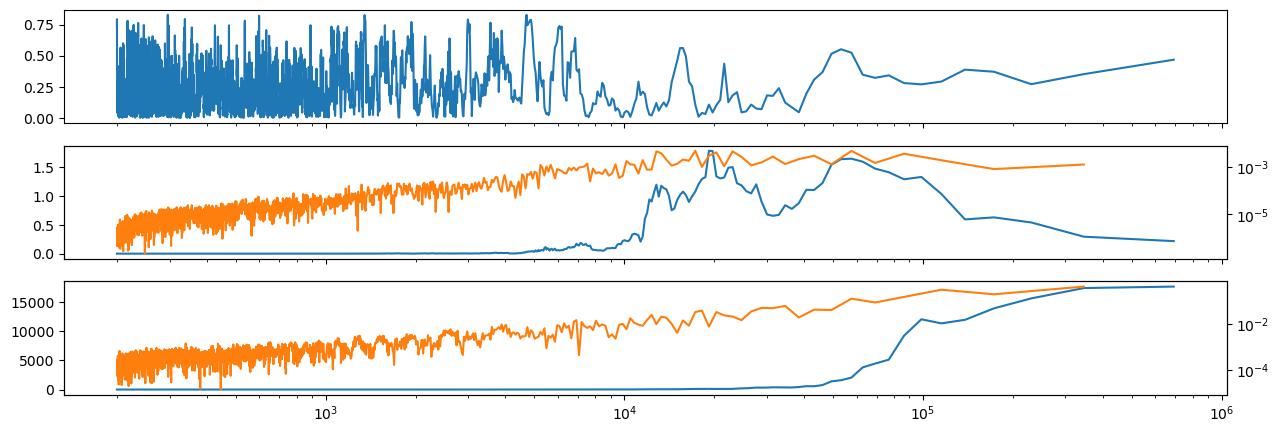

In [159]:
# dat1 = lp[0].data
# dat2 = lp[1].data
# dt, df = lp[0].stats.delta, lp[0].stats.delta

dat1 = st[0].data
dat2 = st[1].data
dt, df = st[0].stats.delta, st[0].stats.delta

out = __multitaper_coherence(dat1, dat2, dt, n_taper=5, time_bandwidth=3.5, method=2)


f1, psd1, pha1 = __get_fft(dat1, df)
f2, psd2, pha2 = __get_fft(dat2, df)



fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

ax[0].semilogx(1/out['fcoh'], out['coh'])

ax[1].semilogx(1/out['ff1'], out['psd1'])
ax[2].semilogx(1/out['ff2'], out['psd2'])

ax11 = ax[1].twinx()
ax11.loglog(1/f1, psd1, color="tab:orange")

ax22 = ax[2].twinx()
ax22.loglog(1/f2, psd2, color="tab:orange")

plt.show();

In [144]:
# dt = st[0].stats.delta
# dat1 = st[0].data
# dat2 = st[1].data

dt = lp[0].stats.delta
dat1 = lp[0].data
dat2 = lp[1].data
# dat2 = np.roll(lp[0].data,50)


twin = 3*3600

ttt, ccf, tlags, shifts, maxima = __cross_correlation_function_windows(dat1, dat2, dt, twin, overlap=0.5, demean=True)



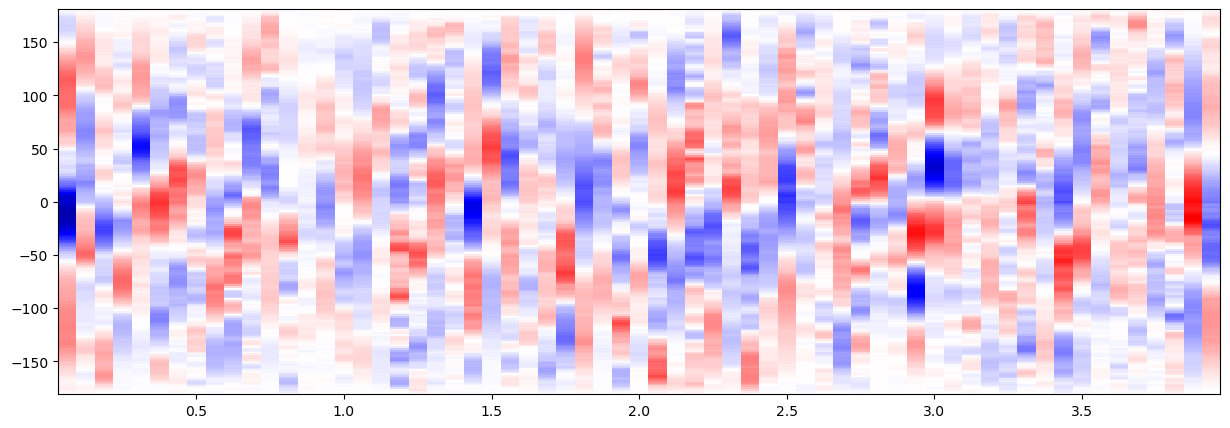

In [145]:
plt.figure(figsize=(15, 5))

cmap = plt.get_cmap("seismic")

plt.pcolormesh(ttt/86400, tlags/60, ccf.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)

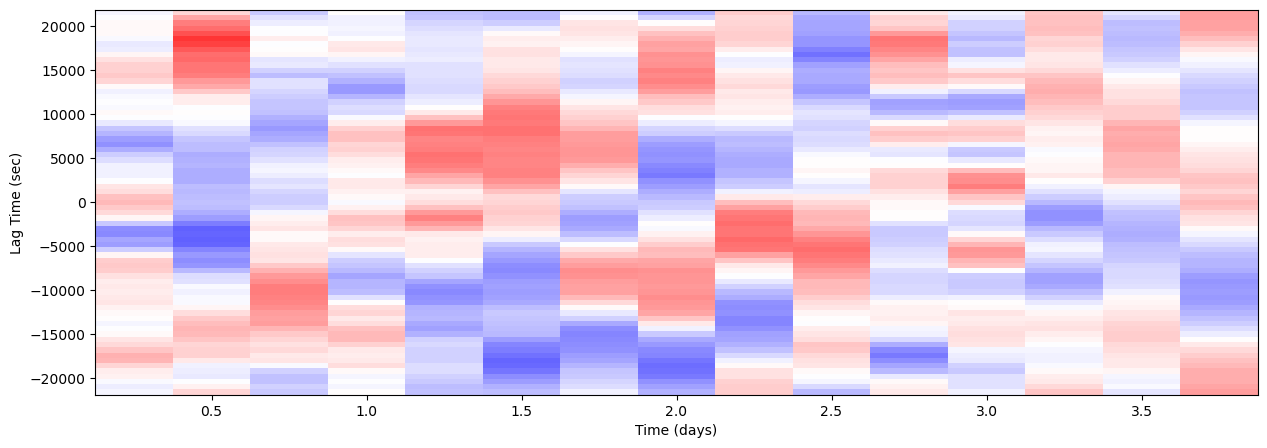

In [146]:
# dt = st[0].stats.delta
# dat1 = st[0].data
# dat2 = st[1].data

dt = lp[0].stats.delta
dat1 = lp[0].data
dat2 = lp[1].data

twin = 12*3600


tt, Tlags, ccc = __cc_lag_matrix(dat1, dat2, dt, twin, 6*3600, 600, plot=True)


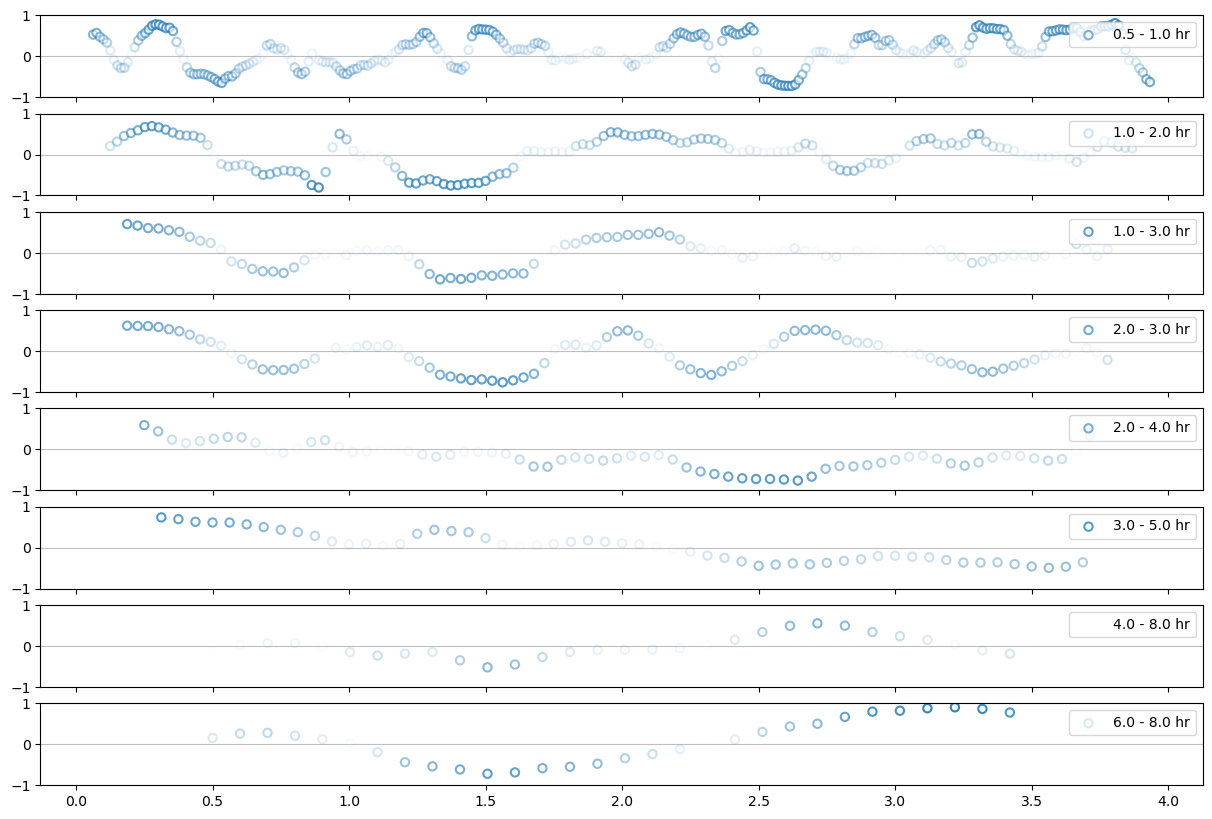

In [148]:
bands = [(0.5, 1.0),(1.0, 2.0), (1.0, 3.0), (2.0, 3.0), (2.0, 4.0), (3.0, 5.0), (4.0, 8.0), (6.0, 8.0)]

fig, ax = plt.subplots(len(bands), 1, figsize=(15, 10), sharex=True)


for _n, band in enumerate(bands):

    flower = 1/(band[1]*3600)
    fupper = 1/(band[0]*3600)

    lp = st.copy()

    lp = lp.detrend("simple")
    lp = lp.taper(0.1)
    lp = lp.filter("bandpass", freqmin=flower, freqmax=fupper, corners=4, zerophase=True)

    tt, cc = __cross_correlation_windows(lp[0].data, lp[1].data, lp[0].stats.delta, 3*band[1]*3600, overlap=0.9, lag=0, demean=False)

    # ax[_n].plot(tt/86400, cc, label=f"{band[0]} - {band[1]} hr", zorder=2)
    ax[_n].scatter(tt/86400, cc, alpha=abs(cc), label=f"{band[0]} - {band[1]} hr", color="w", edgecolor="tab:blue", lw=1.5, zorder=2)

    ax[_n].grid(axis="y", color="grey", zorder=0, alpha=0.5)

    ax[_n].legend(loc=1)

    ax[_n].set_ylim(-1, 1)

plt.show();

In [119]:
from functions.compute_wavelet_coherencey_transform import __compute_wavelet_coherency_transform

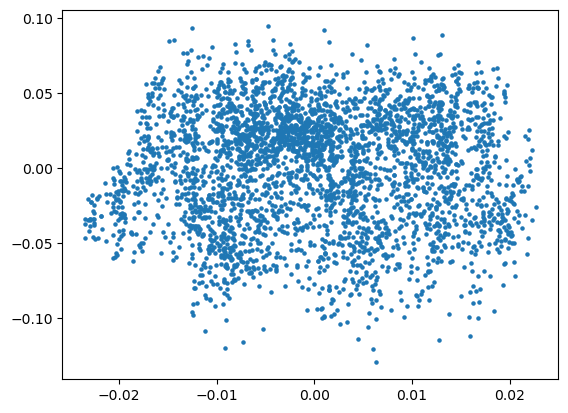

In [120]:
plt.scatter(st[0].data, st[1].data, s=5)